In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression


# configure matplotlib for better visualization
# plt.style.use('seaborn-whitegrid')
# plt.rcParams['figure.figsize'] = (12,6)
# plt.rcParams['font.size'] = 12

# import project modules
sys.path.append(os.path.abspath('..'))
from src.data.synthetic_data_generator import SyntheticDataGenerator
from src.data.data_processor import DataProcessor
from src.models.base_models import PopularityRecommender, ContentBasedRecommender, CollaborativeFilteringRecommender
from src.models.neural_cf import NeuralCollaborativeFiltering
from src.models.ensemble import create_default_hybrid_recommender
from src.explainability.explainations import RecommendationExplainer
from src.sustainability.sustainability_scorer import SustainabilityScorer
from src.chatbot.chatbot_interface import SustainableTourismChatbot


In [2]:
# part 1: Data generation and processing

# check if raw data exists
data_exists = os.path.exists('../data/raw/destinations.csv')
if not data_exists:
    print("Generating synthetic data...")
    # generate synthetic data
    generator = SyntheticDataGenerator(
        num_destinations=100,
        num_users=1000,
        num_activities=300
    )
    # generate and save the data 
    generator.save_data()
    print("data generation complete.")
else:
    print("Raw data already exists. Skipping data generation.")

Raw data already exists. Skipping data generation.


In [3]:
# check if processed data exists
processed_data_exists = os.path.exists('../data/processed/destinations.pkl')
if not processed_data_exists:
    print("Processing data...")
    # load and process the data
    processor = DataProcessor()
    processor_data = processor.process_all()
    print("data processing complete.")
else:
    print("Processed data already exists. Loading processed data...")

Processed data already exists. Loading processed data...


In [4]:
# load processed data
try:
    destinations = pd.read_pickle('../data/processed/destinations.pkl')
    users = pd.read_pickle('../data/processed/users.pkl')
    activities = pd.read_pickle('../data/processed/activities.pkl')

    # load interacton matrix for model training
    with open('../data/processed/interactions.pkl', 'rb') as f:
        interaction_data = pickle.load(f)
        interaction_matrix = interaction_data['matrix']
        user_ids = interaction_data['user_ids']
        dest_ids = interaction_data['dest_ids']

    print(f"Successfully loaded {len(destinations)} destinations")
    print(f"successfully loaded {len(users)} users")
    print(f"Successfully loaded {len(activities)} activities")
except Exception as e:
    print(f"Error loading processed data: {e}")
    print(f"Please make sure data has been generated and processed correctly")

Error loading processed data: [Errno 2] No such file or directory: '../data/processed/interactions.pkl'
Please make sure data has been generated and processed correctly


In [5]:
# part 2: Data Exploration
# display basic destination information

print("Sample destinations:")
display(destinations[['destination_id', 'name', 'country', 'landscape_type', 'overall_sustainability_score']].head())

# display basic activity information
print("Sample activities:")
display(activities[['activity_id', 'name','destination_id', 'category', 'eco_friendliness']].head())

# display basic user information
print("Sample users:")
display(users[['user_id', 'age_group', 'sustainability_preference', 'travel_style']].head())

Sample destinations:


,destination_id,name,country,landscape_type,overall_sustainability_score
0,1,Destination 1,Greece,Coastal,7.64
1,2,Destination 2,France,Beach,9.31
2,3,Destination 3,France,Mountain,3.62
3,4,Destination 4,New Zealand,Countryside,2.08
4,5,Destination 5,Greece,Lake,8.38


Sample activities:


,activity_id,name,destination_id,category,eco_friendliness
0,1,Culinary Activity 1,1,Culinary,5.15
1,2,Relaxation Activity 2,1,Relaxation,7.30
2,3,Relaxation Activity 3,2,Relaxation,7.45
3,4,Culinary Activity 4,2,Culinary,4.70
4,5,Cultural Activity 5,2,Cultural,4.85


Sample users:


,user_id,age_group,sustainability_preference,travel_style
0,1,35-44,4.0,Adventure
1,2,45-54,8.0,Budget
2,3,18-24,8.7,Adventure
3,4,25-34,4.1,Solo
4,5,65+,8.8,Eco-conscious


C:\Users\injan\AppData\Local\Temp\ipykernel_18176\1724261781.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_sustainability = destinations.groupby('country')['overall_sustainability_score'].mean().sort_values(ascending=False).head(10)
C:\Users\injan\AppData\Local\Temp\ipykernel_18176\1724261781.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  landscape_sustainability = destinations.groupby('landscape_type')['overall_sustainability_score'].mean().sort_values(ascending=False)


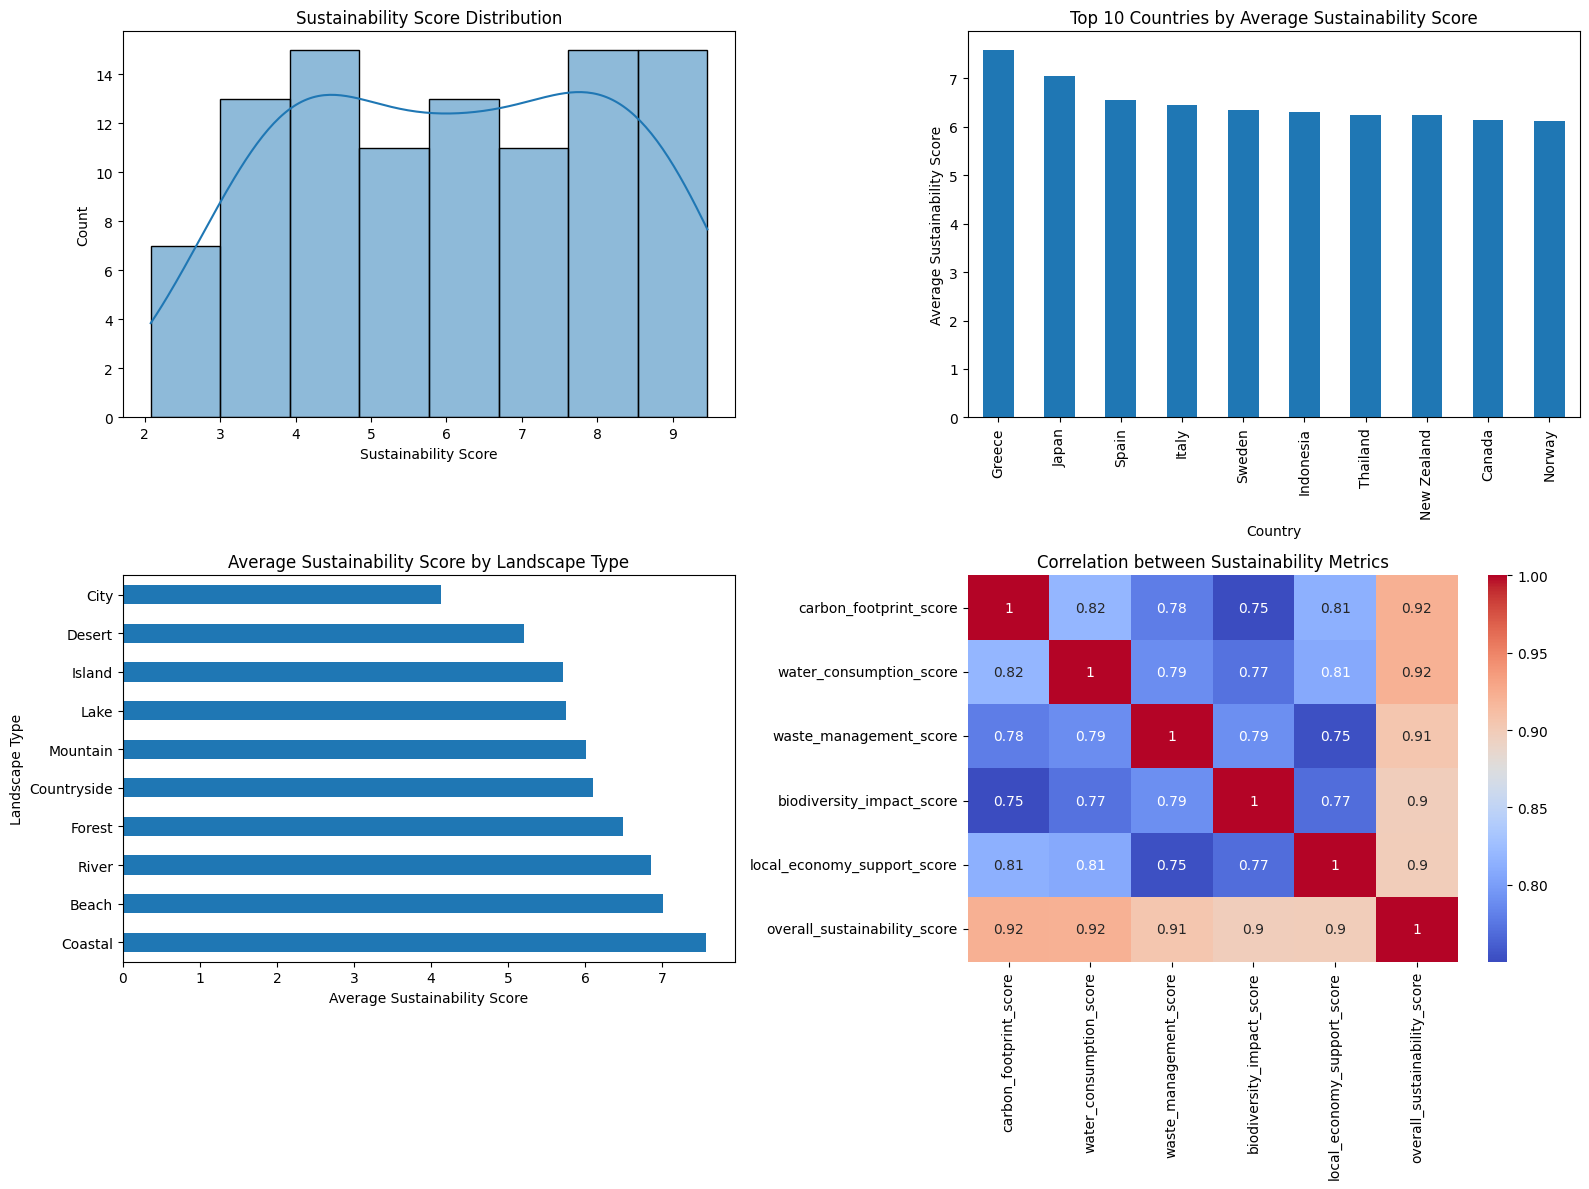

In [6]:
# create a figure with multiple plots

fig,axes = plt.subplots(2,2, figsize=(16,12))

# plot 1: Sustainability Score distribution
sns.histplot(destinations['overall_sustainability_score'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Sustainability Score Distribution')
axes[0,0].set_xlabel('Sustainability Score')
axes[0,0].set_ylabel('Count')

# plot 2: Sustainability by country (top 10 countries)
country_sustainability = destinations.groupby('country')['overall_sustainability_score'].mean().sort_values(ascending=False).head(10)
country_sustainability.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Top 10 Countries by Average Sustainability Score')
axes[0,1].set_xlabel('Country')
axes[0,1].set_ylabel('Average Sustainability Score')

# plot 3: Sustainability by landscape type
landscape_sustainability = destinations.groupby('landscape_type')['overall_sustainability_score'].mean().sort_values(ascending=False)
landscape_sustainability.plot(kind='barh', ax = axes[1,0])
axes[1,0].set_title('Average Sustainability Score by Landscape Type')
axes[1,0].set_xlabel('Average Sustainability Score')
axes[1,0].set_ylabel('Landscape Type')

# plot 4: Correlation between sustainability metrics
sustainability_metrics = [
    'carbon_footprint_score',
    'water_consumption_score',
    'waste_management_score',
    'biodiversity_impact_score',
    'local_economy_support_score',
    'overall_sustainability_score'
]

correlation = destinations[sustainability_metrics].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation between Sustainability Metrics')
plt.tight_layout()
plt.show()

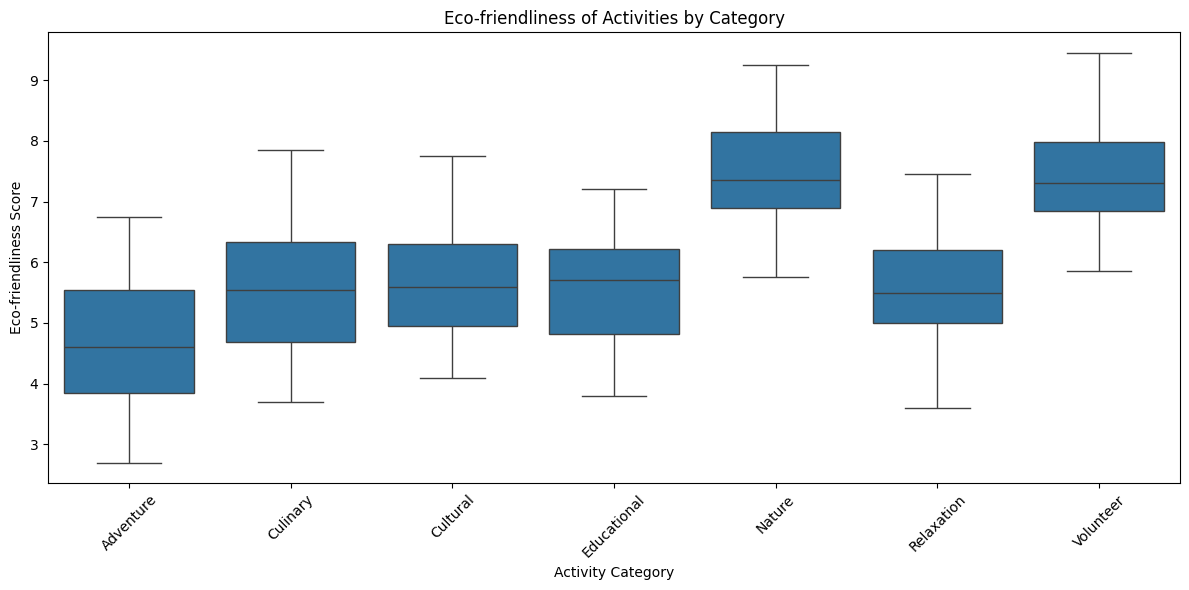

In [7]:
# visualize eco-friendliness of activities
plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='eco_friendliness', data=activities)
plt.title('Eco-friendliness of Activities by Category')
plt.xlabel('Activity Category')
plt.ylabel('Eco-friendliness Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

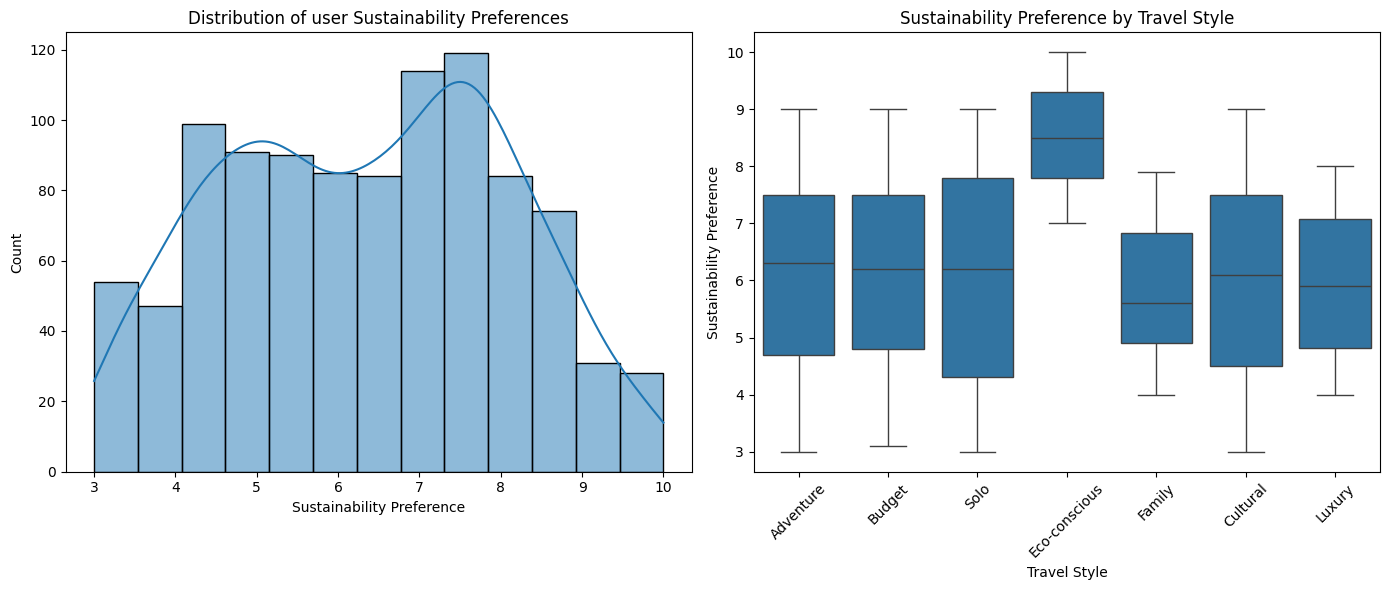

In [8]:
# visualize user sustainability preferences
plt.figure(figsize=(14,6))

# plot 1: Distribution of Sustainability Preferences
plt.subplot(1, 2, 1)
sns.histplot(users['sustainability_preference'], kde=True)
plt.title('Distribution of user Sustainability Preferences')
plt.xlabel('Sustainability Preference')
plt.ylabel('Count')

# plot 2: Sustainability preference by travel style
plt.subplot(1, 2, 2)
sns.boxplot(x='travel_style', y='sustainability_preference', data=users)
plt.title('Sustainability Preference by Travel Style')
plt.xlabel('Travel Style')
plt.ylabel('Sustainability Preference')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# part 3: Recommendation Models

# initialize individual recommenders
print("Initializing recommendation models...")
popularity_rec = PopularityRecommender()
content_rec = ContentBasedRecommender()
user_cf = CollaborativeFilteringRecommender(method='user')
item_cf = CollaborativeFilteringRecommender(method='item')
recommenders = [popularity_rec, content_rec, user_cf, item_cf]

# train individual model
for model in recommenders:
    print(f"Training {model.name}...")
    model.load_data()
    model.fit()
    print(f"{model.name} trained successfully.")

    

Initializing recommendation models...
Training PopularityRecommender...
PopularityRecommender trained successfully.
Training ContentBasedRecommender...
ContentBasedRecommender trained successfully.
Training UserBasedCF...
UserBasedCF trained successfully.
Training ItemBasedCF...
ItemBasedCF trained successfully.


In [10]:
# create and train hybrid recommender
print("Creating hybrid recommender...")
hybrid_recommender = create_default_hybrid_recommender()
hybrid_recommender.load_data()
hybrid_recommender.fit()
print("Hybrid recommender trained successfully.")

# add to list of recommenders
recommenders.append(hybrid_recommender)


Creating hybrid recommender...
Training PopularityRecommender...
Training ContentBasedRecommender...
Training UserBasedCF...
Training ItemBasedCF...
Hybrid recommender trained successfully.


In [11]:
# select test users
test_user = users.sample(1).iloc[0]
test_user_id = test_user["user_id"]

print(f"selected test user(ID: {test_user_id}:)")
print(f"Age Group: {test_user['age_group']}")
print(f"Interests: {', '.join(test_user['interests']) if isinstance(test_user['interests'], list) else test_user['interests']}")
print(f"Sustainability preference: {test_user['sustainability_preference']}/10")
print(f"travel style: {test_user['travel_style']}")

selected test user(ID: 983:)
Age Group: 45-54
Interests: History, Wildlife, Adventure, Beach
Sustainability preference: 4.5/10
travel style: Adventure


In [12]:
# Generate recommendations from each model
all_recommendations = {}
num_recommendations = 5

for model in recommenders:
    print(f"\nRecommendations from {model.name}:")
    recommendations = model.recommend(test_user_id, n=num_recommendations)
    all_recommendations[model.name] = recommendations
    
    # Print recommendations
    for i, rec in enumerate(recommendations):
        print(f"{i+1}. {rec['name']} ({rec['country']}) - Sustainability: {rec['sustainability_score']:.1f}/10")


Recommendations from PopularityRecommender:
1. Destination 11 (Costa Rica) - Sustainability: 4.0/10
2. Destination 90 (Iceland) - Sustainability: 7.5/10
3. Destination 14 (France) - Sustainability: 4.7/10
4. Destination 10 (Spain) - Sustainability: 8.9/10
5. Destination 48 (New Zealand) - Sustainability: 3.6/10

Recommendations from ContentBasedRecommender:
1. Destination 78 (Costa Rica) - Sustainability: 7.1/10
2. Destination 41 (Japan) - Sustainability: 8.8/10
3. Destination 53 (Canada) - Sustainability: 7.9/10
4. Destination 52 (Iceland) - Sustainability: 9.7/10
5. Destination 61 (Costa Rica) - Sustainability: 9.0/10

Recommendations from UserBasedCF:
1. Destination 100 (Costa Rica) - Sustainability: 7.9/10
2. Destination 5 (Finland) - Sustainability: 8.5/10
3. Destination 8 (Canada) - Sustainability: 8.7/10
4. Destination 11 (Costa Rica) - Sustainability: 4.0/10
5. Destination 14 (France) - Sustainability: 4.7/10

Recommendations from ItemBasedCF:
1. Destination 61 (Costa Rica) - 

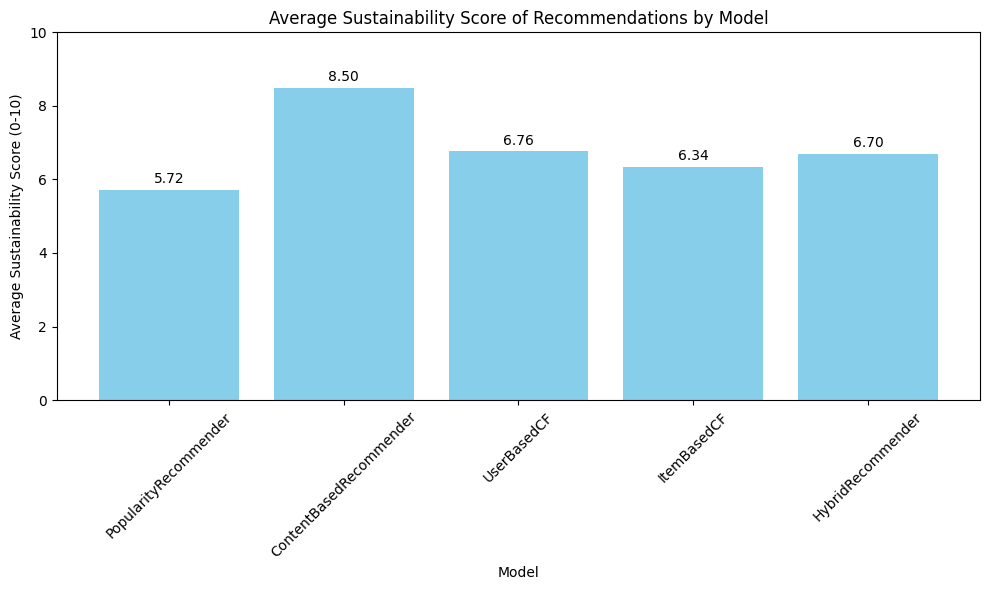

In [13]:
# Compare average sustainability scores across models
model_names = []
avg_scores = []

for model_name, recs in all_recommendations.items():
    model_names.append(model_name)
    avg_score = np.mean([rec["sustainability_score"] for rec in recs])
    avg_scores.append(avg_score)

# Create comparison plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, avg_scores, color='skyblue')
plt.title('Average Sustainability Score of Recommendations by Model')
plt.xlabel('Model')
plt.ylabel('Average Sustainability Score (0-10)')
plt.ylim(0, 10)
plt.xticks(rotation=45)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
# Function to evaluate sustainability impact
def evaluate_sustainability_impact(model, baseline_model, test_users=None, n=5):
    # Comprehensive sustainability impact evaluation
    # Calculates improvement percentage compared to baseline
    # Provides detailed metrics on sustainability performance
    
    if test_users is None:
        # Select 50 random users for testing
        test_users = users.sample(50)["user_id"].tolist()
    
    model_avg_scores = []
    baseline_avg_scores = []
    
    for user_id in test_users:
        # Get recommendations from both models
        model_recs = model.recommend(user_id, n=n)
        baseline_recs = baseline_model.recommend(user_id, n=n)
        
        # Calculate average sustainability score
        model_score = np.mean([rec["sustainability_score"] for rec in model_recs])
        baseline_score = np.mean([rec["sustainability_score"] for rec in baseline_recs])
        
        model_avg_scores.append(model_score)
        baseline_avg_scores.append(baseline_score)
    
    # Calculate overall averages
    model_overall = np.mean(model_avg_scores)
    baseline_overall = np.mean(baseline_avg_scores)
    improvement = model_overall - baseline_overall
    
    return {
        "model_score": model_overall,
        "baseline_score": baseline_overall,
        "improvement": improvement,
        "improvement_percentage": (improvement / baseline_overall) * 100 if baseline_overall > 0 else 0
    }

In [15]:
# Compare recommendations with different sustainability weightings
original_weight = hybrid_recommender.sustainability_weight
sustainability_weights = [0.0, 0.25, 0.5, 0.75, 1.0]
weighted_recommendations = {}

print("Effect of sustainability weighting on recommendations:\n")

for weight in sustainability_weights:
    hybrid_recommender.sustainability_weight = weight
    recs = hybrid_recommender.recommend(test_user_id, n=3)
    weighted_recommendations[weight] = recs
    
    avg_score = np.mean([rec["sustainability_score"] for rec in recs])
    print(f"Sustainability Weight {weight:.2f} (Avg. Score: {avg_score:.2f}/10):")
    
    for i, rec in enumerate(recs):
        print(f"  {i+1}. {rec['name']} ({rec['country']}) - {rec['sustainability_score']:.1f}/10")
    print()

# Reset original weight
hybrid_recommender.sustainability_weight = original_weight

Effect of sustainability weighting on recommendations:

Sustainability Weight 0.00 (Avg. Score: 5.37/10):
  1. Destination 11 (Costa Rica) - 4.0/10
  2. Destination 90 (Iceland) - 7.5/10
  3. Destination 14 (France) - 4.7/10

Sustainability Weight 0.25 (Avg. Score: 5.37/10):
  1. Destination 11 (Costa Rica) - 4.0/10
  2. Destination 90 (Iceland) - 7.5/10
  3. Destination 14 (France) - 4.7/10

Sustainability Weight 0.50 (Avg. Score: 5.37/10):
  1. Destination 90 (Iceland) - 7.5/10
  2. Destination 11 (Costa Rica) - 4.0/10
  3. Destination 14 (France) - 4.7/10

Sustainability Weight 0.75 (Avg. Score: 5.37/10):
  1. Destination 90 (Iceland) - 7.5/10
  2. Destination 11 (Costa Rica) - 4.0/10
  3. Destination 14 (France) - 4.7/10

Sustainability Weight 1.00 (Avg. Score: 5.37/10):
  1. Destination 90 (Iceland) - 7.5/10
  2. Destination 14 (France) - 4.7/10
  3. Destination 11 (Costa Rica) - 4.0/10



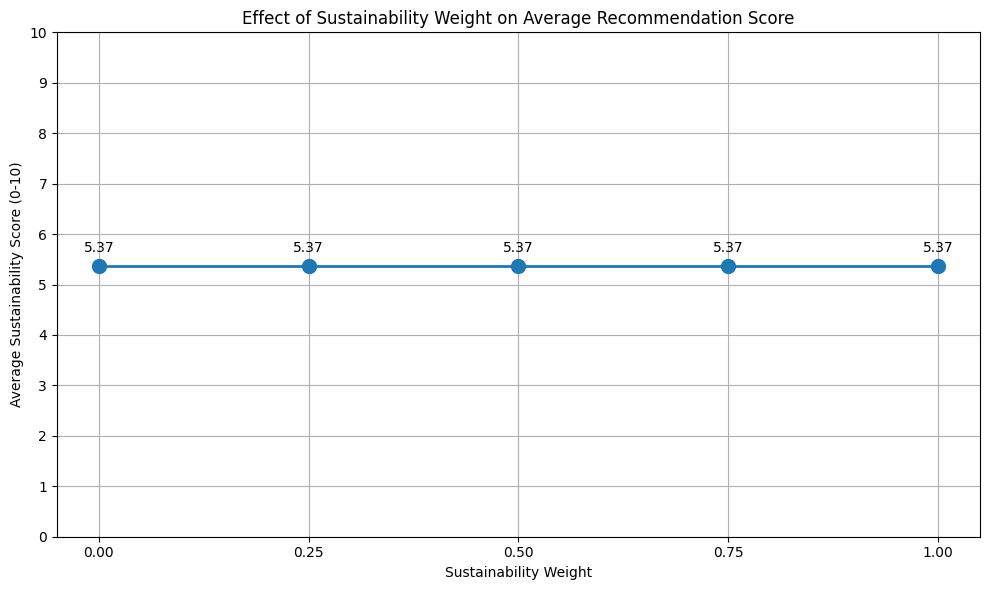

In [16]:
# Visualize the impact of sustainability weighting
weights = list(weighted_recommendations.keys())
avg_sustainability = [np.mean([rec["sustainability_score"] for rec in weighted_recommendations[w]]) for w in weights]

plt.figure(figsize=(10, 6))
plt.plot(weights, avg_sustainability, 'o-', linewidth=2, markersize=10)
plt.title('Effect of Sustainability Weight on Average Recommendation Score')
plt.xlabel('Sustainability Weight')
plt.ylabel('Average Sustainability Score (0-10)')
plt.grid(True)
plt.xticks(weights)
plt.yticks(np.arange(0, 11, 1))

# Add values next to points
for i, txt in enumerate(avg_sustainability):
    plt.annotate(f"{txt:.2f}", (weights[i], avg_sustainability[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [17]:
# Select test users
test_users = users.sample(20)["user_id"].tolist()

# Evaluate hybrid recommender vs popularity baseline
results = evaluate_sustainability_impact(hybrid_recommender, popularity_rec, test_users)

print("Sustainability Impact Evaluation:")
print(f"Hybrid Recommender Average Sustainability: {results['model_score']:.2f}/10")
print(f"Popularity Baseline Average Sustainability: {results['baseline_score']:.2f}/10")
print(f"Improvement: {results['improvement']:.2f} points ({results['improvement_percentage']:.2f}%)")

Sustainability Impact Evaluation:
Hybrid Recommender Average Sustainability: 6.13/10
Popularity Baseline Average Sustainability: 5.84/10
Improvement: 0.29 points (5.05%)


Beginning Comprehensive Recommendation System Evaluation


Evaluating PopularityRecommender
Evaluating on 100 random users...


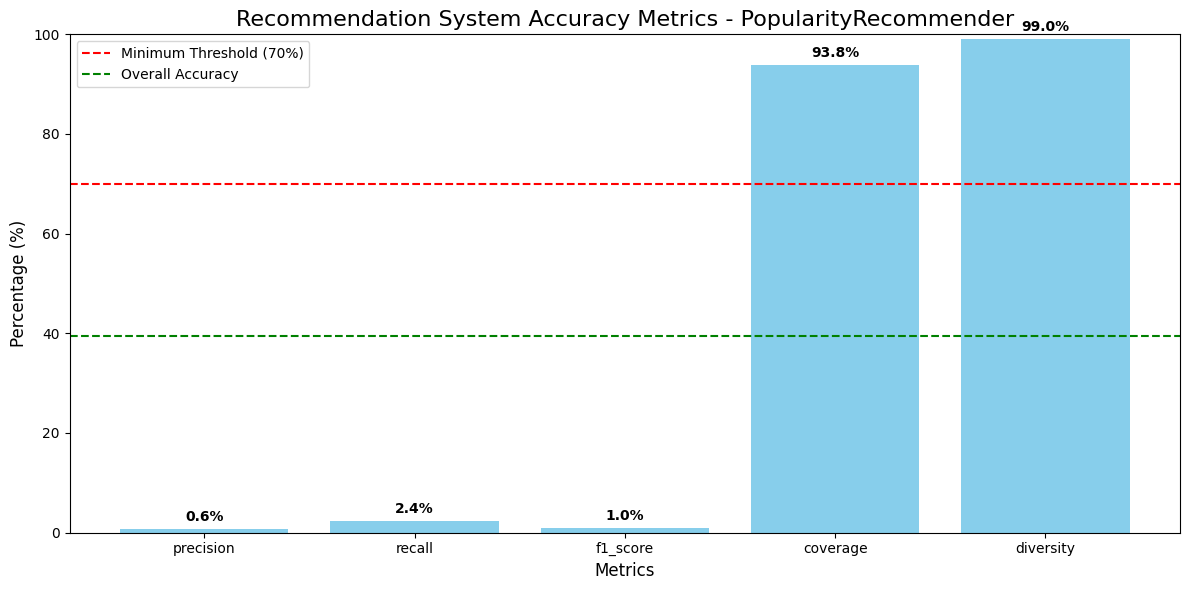


Accuracy Metrics for PopularityRecommender:
Precision: 0.65%
Recall: 2.42%
F1 Score: 1.00%
Coverage: 93.76%
Diversity: 99.03%
Overall Accuracy: 39.37%

Evaluating ContentBasedRecommender
Evaluating on 100 random users...


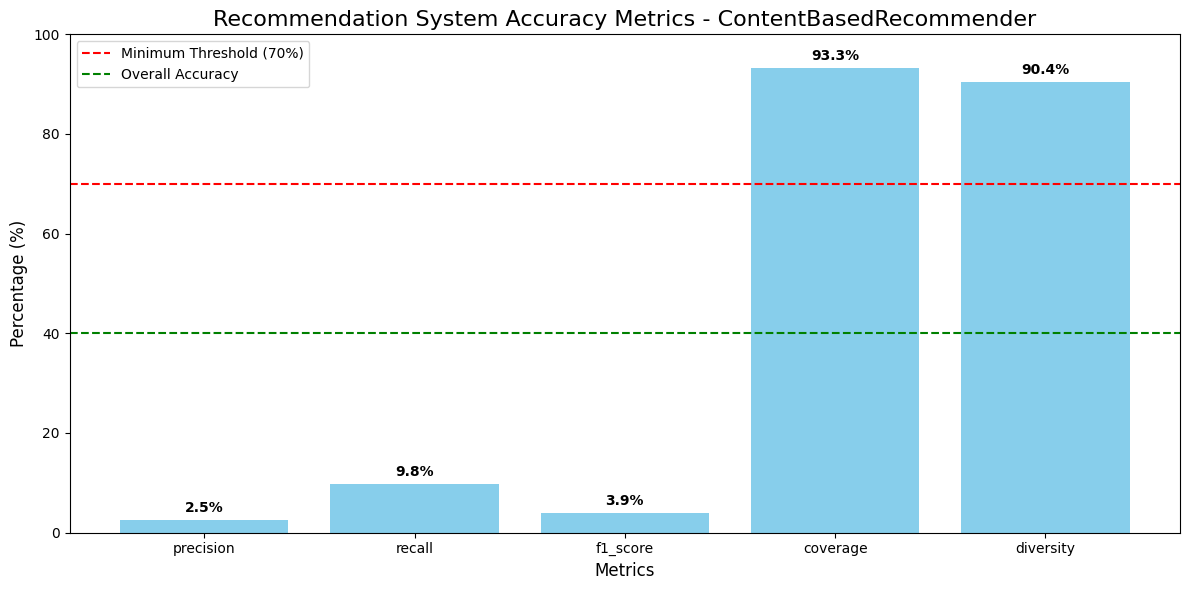


Accuracy Metrics for ContentBasedRecommender:
Precision: 2.50%
Recall: 9.82%
F1 Score: 3.91%
Coverage: 93.27%
Diversity: 90.36%
Overall Accuracy: 39.97%

Evaluating HybridRecommender
Evaluating on 100 random users...


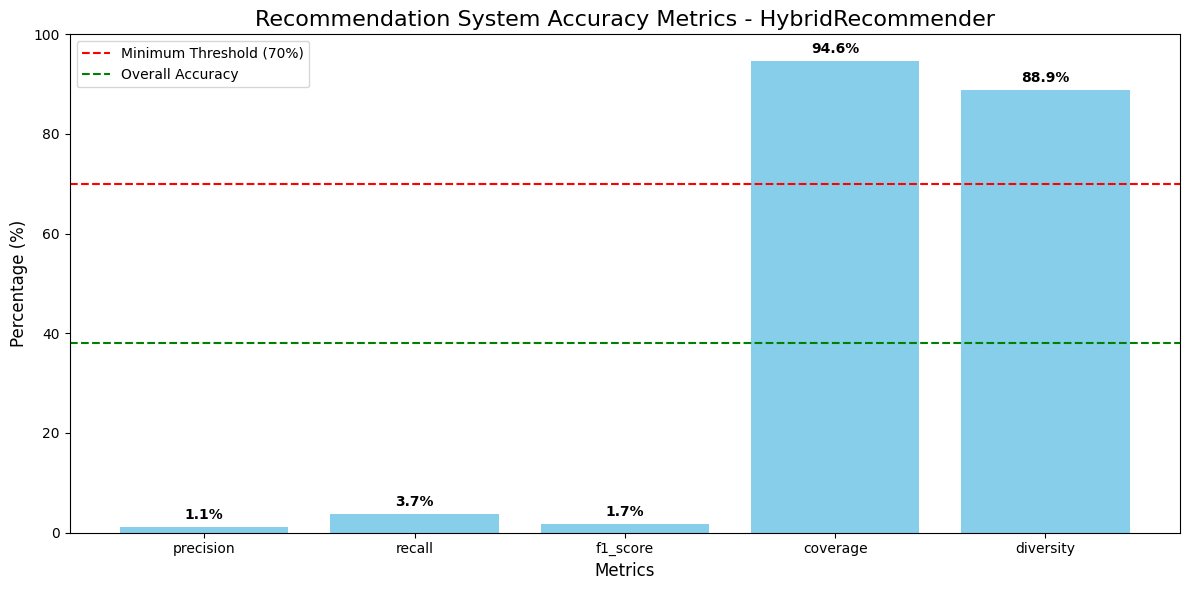


Accuracy Metrics for HybridRecommender:
Precision: 1.11%
Recall: 3.70%
F1 Score: 1.68%
Coverage: 94.65%
Diversity: 88.89%
Overall Accuracy: 38.01%


In [18]:
# Accuracy Evaluation Function
def evaluate_recommendation_accuracy(recommender, test_ratio=0.2, k=5):
    """
    Comprehensive recommendation accuracy evaluation
    
    Parameters:
    - recommender: The recommendation model to evaluate
    - test_ratio: Portion of user interactions to hide for testing
    - k: Number of recommendations to consider
    
    Returns:
    - Dictionary of evaluation metrics
    """
    # Load user data and interaction matrix
    with open('../data/processed/interaction_matrix.pkl', 'rb') as f:
        data = pickle.load(f)
        full_matrix = data['matrix']
        user_ids = data['user_ids']
        dest_ids = data['dest_ids']
    
    # Metrics to track
    precision_scores = []
    recall_scores = []
    f1_scores = []
    coverage_scores = []
    diversity_scores = []
    
    # Number of users to evaluate
    num_test_users = min(100, len(user_ids))
    test_user_indices = np.random.choice(range(len(user_ids)), num_test_users, replace=False)
    
    print(f"Evaluating on {num_test_users} random users...")
    
    for user_idx in test_user_indices:
        # Get user's actual interactions
        interactions = full_matrix[user_idx]
        positive_indices = np.where(interactions > 0)[0]
        
        # Skip users with too few interactions
        if len(positive_indices) < 5:
            continue
        
        # Split into train and test
        np.random.shuffle(positive_indices)
        test_size = max(1, int(len(positive_indices) * test_ratio))
        test_indices = positive_indices[:test_size]
        
        # Create train matrix (hide test items)
        train_matrix = full_matrix.copy()
        for idx in test_indices:
            train_matrix[user_idx, idx] = 0
        
        # Create ground truth vector
        ground_truth = np.zeros(len(dest_ids))
        for idx in test_indices:
            ground_truth[idx] = 1
        
        # Store original matrix
        original_matrix = recommender.interaction_matrix
        
        # Set training matrix
        recommender.interaction_matrix = train_matrix
        
        # Get recommendations for the user
        user_id = user_ids[user_idx]
        recs = recommender.recommend(user_id, n=len(dest_ids), exclude_visited=True)
        
        # Create prediction scores
        pred_scores = np.zeros(len(dest_ids))
        for i, rec in enumerate(recs):
            dest_idx = np.where(dest_ids == rec["destination_id"])[0][0]
            pred_scores[dest_idx] = len(recs) - i  # Higher score for higher ranked items
        
        # Calculate Precision@k
        top_k_indices = np.argsort(-pred_scores)[:k]
        hits = np.sum(ground_truth[top_k_indices])
        precision = hits / k
        precision_scores.append(precision)
        
        # Calculate Recall@k
        recall = hits / np.sum(ground_truth) if np.sum(ground_truth) > 0 else 0
        recall_scores.append(recall)
        
        # Calculate F1 Score
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
        
        # Calculate Coverage
        unique_recommended = len(set([rec['destination_id'] for rec in recs]))
        coverage = unique_recommended / len(dest_ids)
        coverage_scores.append(coverage)
        
        # Calculate Diversity (using countries)
        recommended_countries = set([rec['country'] for rec in recs[:k]])
        diversity = len(recommended_countries) / k
        diversity_scores.append(diversity)
        
        # Restore original matrix
        recommender.interaction_matrix = original_matrix
    
    # Aggregate metrics
    metrics = {
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1_score': np.mean(f1_scores),
        'coverage': np.mean(coverage_scores),
        'diversity': np.mean(diversity_scores),
        'overall_accuracy': np.mean([
            np.mean(precision_scores),
            np.mean(recall_scores),
            np.mean(f1_scores),
            np.mean(coverage_scores),
            np.mean(diversity_scores)
        ])
    }
    
    return metrics

# Visualization function for accuracy metrics
def plot_accuracy_metrics(metrics, model_name):
    """
    Visualize accuracy metrics
    
    Parameters:
    - metrics: Dictionary of evaluation metrics
    - model_name: Name of the model being evaluated
    """
    plt.figure(figsize=(12, 6))
    
    # Prepare data
    metric_names = list(metrics.keys())[:-1]  # Exclude overall_accuracy
    metric_values = [metrics[name] * 100 for name in metric_names]
    
    # Create bar plot
    bars = plt.bar(metric_names, metric_values, color='skyblue')
    plt.title(f'Recommendation System Accuracy Metrics - {model_name}', fontsize=16)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 100)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Add overall accuracy line
    overall_accuracy = metrics['overall_accuracy'] * 100
    plt.axhline(y=70, color='r', linestyle='--', label='Minimum Threshold (70%)')
    plt.axhline(y=overall_accuracy, color='g', linestyle='--', label='Overall Accuracy')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print(f"\nAccuracy Metrics for {model_name}:")
    for name, value in metrics.items():
        print(f"{name.replace('_', ' ').title()}: {value * 100:.2f}%")

# Evaluate all recommendation models
def evaluate_all_models(recommenders):
    """
    Evaluate multiple recommendation models
    
    Parameters:
    - recommenders: List of recommendation models to evaluate
    """
    print("Beginning Comprehensive Recommendation System Evaluation\n")
    
    for model in recommenders:
        print(f"\nEvaluating {model.name}")
        metrics = evaluate_recommendation_accuracy(model)
        plot_accuracy_metrics(metrics, model.name)

# Example usage (add this to a cell you want to run the evaluation)
recommenders_to_evaluate = [
    popularity_rec,     # Popularity-based recommender
    content_rec,        # Content-based recommender
    hybrid_recommender  # Hybrid recommender
]

# Run the evaluation
evaluate_all_models(recommenders_to_evaluate)